<a href="https://colab.research.google.com/github/ram130849/VQ_VAE/blob/main/VQ_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 12.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=9b5e6fcc12a60153bd90d78b82c90119c9ae89a416742750c737180392020155
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=6f3eb8186e3a9038657bfb912be1c2d305c1506ac15ae4e0f806473e8001eb74
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import umap


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print(device)

cuda


In [8]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(1,1,1))
                                 ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data


In [9]:
validation_data = datasets.CIFAR10(root="data",train=False,download=True,
                                   transform = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(1.0,1.0,1.0))
                                   ]))

Files already downloaded and verified


In [10]:
data_var = np.var(training_data.data/255.0)

In [11]:
class VectorQuantizer(nn.Module):
    def __init__(self,no_embeddings:int,embedding_dim:int,commit_loss:float):
        super(VectorQuantizer,self).__init__()
        self.K = no_embeddings
        self.D = embedding_dim
        self.commit_loss = commit_loss

        self.embedding = nn.Embedding(self.K,self.D)
        self.embedding.weight.data.uniform(-1/self.K,1/self.K)

    def forward(self,latents):
        # convert the input from BCHW --> BHWC
        latents = latents.permute(0,2,3,1).contiguous()
        latent_shape = latents.shape

        # Flatten_Input.
        flat_input = latents.view(-1,self.D)

        # Calculate L2 distances between the latent space and embedding weights
        distances = (torch.sum(flat_input**2,dim=1,keepdim=True)+torch.sm(self.embedding.weight**2,dim=1)- 
                     2*torch.matmul(flat_input,self.embedding.weight.t()))

        # Encoding - get the encoding that has the min distance and convert it to one-hot encodings.
        encoding_idx = torch.argmin(distances,dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_idx.shape[0],self.K,device=latents.device)
        encodings.scatter_(1,encoding_idx,1) # [BHW * K]

        # Quantize and unflatten the latents.
        quantized = torch.matmul(encodings,self.embedding.weight).view(latent_shape) # [BHW,D] --> [B*H*W*D]

        # Loss
        commitment_loss = F.mse_loss(quantized.detach(),latents)
        embedding_loss  = F.mse_loss(quantized,latents.detach())

        vq_loss = commitment_loss * self.commit_loss + embedding_loss

        quantized = latents + (quantized - latents).detach() 
        # convert quantized from BHWC --> BCHW
        return quantized.permute(0,3,1,2).contiguous(), vq_loss # [B*C*H*W]

In [ ]:
### We will also implement a slightly modified version which will use exponential moving averages to update the embedding vectors instead of an 
### auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other 
### parts of the architecture.For most experiments the EMA version trains faster than the non-EMA version.

In [12]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self,no_embeddings,embedding_dim,commit_loss,decay,epsilon=1e-5):
        super(VectorQuantizerEMA,self).__init__()
        self.K = no_embeddings
        self.D = embedding_dim

        self.embedding = nn.Embedding(self.K,self.D)
        self.embedding.weight.data.normal_()
        self.commit_loss = commit_loss

        self.register_buffer('_ema_cluster_size',torch.zeros(self.K))
        self.ema_w = nn.Parameter(torch.Tensor(self.K,self.D))
        self.ema_w.data.normal_()

        self.decay = decay
        self.epsilon = epsilon

    def forward(self,latents):
        # convert inputs from BCHW --> BHWC
        latents = latents.permute(0,2,3,1).contiguous()
        latent_shape = latents.shape

        # Flatten_Input
        flat_input = latents.view(-1,self.D)

        # Calculate Distances.
        distances = (torch.sum(flat_input**2,dim=1,keepdim=True)+
                     torch.sum(self.embedding.weight**2,dim=1)
                     - 2*torch.matmul(flat_input,self.embedding.weight.t()))
        # Encoding
        encoding_idx = torch.argmin(distances,dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_idx.shape[0],self.K,device=latents.device)
        encodings.scatter_(1,encoding_idx,1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings,self.embedding.weight).view(latent_shape)

        # Use EMA to update the embedding vectors
        if(self.training):
            self._ema_cluster_size = self._ema_cluster_size*self.decay + (1-self.decay) * torch.sum(encodings,0)

            # Laplace Smoothing of the cluster Size.
            ema_cluster_sum = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = ((self._ema_cluster_size + self.epsilon)/(ema_cluster_sum + self.K*self.epsilon)*ema_cluster_sum)
            dw = torch.matmul(encodings.t(),flat_input)
            self.ema_w = nn.Parameter(self.ema_w*self.decay + (1-self.decay)*dw)
            self.embedding.weight = nn.Parameter(self.ema_w/ self._ema_cluster_size.unsqueeze(1))

        # Loss
        commitment_loss = F.mse_loss(quantized.detach(),latents)
        loss = self.commit_loss*commitment_loss

        # Straight through Estimator
        quantized = latents + (quantized - latents).detach()
        avg_probs = torch.mean(encodings,dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs*torch.log(avg_probs+1e-10)))

        #convert quantized from BHWC --> BCHW
        return loss, quantized.permute(0,3,1,2).contiguous(), perplexity, encodings

In [13]:
class Residual(nn.Module):
    def __init__(self,input_chnl,no_hidden,no_residual_hidden):
        super(Residual,self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=input_chnl,out_channels=no_residual_hidden,
                      kernel_size=3,stride=1,padding=1,bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=no_residual_hidden,out_channels=no_hidden,
                      kernel_size=1,stride=1,bias=False)
        )
    def forward(self,x):
        return x + self._block(x)

In [14]:
class ResidualStack(nn.Module):
    def __init__(self,in_channels,no_hiddens,no_residual_layers,no_residual_hidden):
      super(ResidualStack,self).__init__()
      self._no_residual_layers = no_residual_layers
      self._layers = nn.ModuleList([Residual(input_chnl=in_channels,no_hidden=no_hiddens,no_residual_hidden=no_residual_hidden)
                                     for _ in range(self._no_residual_layers)])
      
    def forward(self,x):
      for i in range(self._no_residual_layers):
            x = self._layers[i](x)
      return F.relu(x)

In [15]:
class Encoder(nn.Module):
    def __init__(self,in_channels,no_hiddens,no_residual_layers,no_residual_hidden):
        super(Encoder,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=no_hiddens//2,
                               kernel_size=4,
                               stride=2,padding=1)

        self.conv2 = nn.Conv2d(in_channels=no_hiddens//2,
                               out_channels=no_hiddens,
                               kernel_size=4,
                               stride=2,padding=1)

        self.conv3 = nn.Conv2d(in_channels=no_hiddens,
                               out_channels=no_hiddens,
                               kernel_size=3,
                               stride=1,padding=1)

        self._residual_stack = ResidualStack(in_channels=no_hiddens,no_hiddens=no_hiddens,
                                             no_residual_layers = no_residual_layers,
                                             no_residual_hidden=no_residual_hidden)
        
    def forward(self,latents):
        x = self.conv1(latents)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        return self._residual_stack(x)

In [16]:
class Decoder(nn.Module):
    def __init__(self,in_channels,no_hiddens,no_residual_layers,no_residual_hidden):
          super(Decoder,self).__init__()
          self._conv1 = nn.Conv2d(in_channels=in_channels,
                                  out_channels = no_hiddens,
                                  kernel_size=3,stride=1,padding=1)

          self.residual_stack = ResidualStack(in_channels=no_hiddens,
                                              no_hiddens = no_hiddens,
                                              no_residual_layers = no_residual_layers
                                              ,no_residual_hidden=no_residual_hidden)

          self._conv_trans_1 = nn.ConvTranspose2d(in_channels=no_hiddens,
                                                  out_channels = no_hiddens//2,
                                                  kernel_size=4,stride=2,
                                                  padding=1)

          self._conv_trans_2 = nn.ConvTranspose2d(in_channels=no_hiddens//2,
                                                  out_channels = 3,
                                                  kernel_size=4,stride=2,
                                                  padding=1)
    def forward(self,inputs):
        x = self._conv1(inputs)

        x = self.residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

In [17]:
batch_size = 256
no_training_updates = 15000
no_hiddens = 128
no_residual_hidden = 32
no_residual_layers = 34

embedding_dim = 64
no_embeddings = 512

commit_loss = 0.25
decay = 0.90
lr = 0.001

In [18]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

In [19]:
class Model(nn.Module):
    def __init__(self,no_hiddens,no_residual_layers,no_residual_hidden,no_embeddings,embedding_dim,commit_loss,decay=0):
        super(Model,self).__init__()

        self._encoder = Encoder(3,no_hiddens,
                                no_residual_layers,
                                no_residual_hidden)

        self.pre_vq_conv = nn.Conv2d(in_channels = no_hiddens,
                                     out_channels = embedding_dim,
                                     kernel_size=1,stride=1)
        
        if(decay>0.0):
            self._vq_vae = VectorQuantizerEMA(no_embeddings,embedding_dim,commit_loss,decay)
        else:
            self._vq_vae = VectorQuantizer(no_embeddings,embedding_dim,commit_loss)
        
        self._decoder = Decoder(in_channels = embedding_dim,
                                no_hiddens = no_hiddens,
                                no_residual_layers = no_residual_layers,
                                no_residual_hidden=no_residual_hidden)

    def forward(self,x):
        z = self._encoder(x)

        z = self.pre_vq_conv(z)

        loss,quantized,perplexity,_ = self._vq_vae(z)

        x_recon = self._decoder(quantized)

        return loss,x_recon,perplexity
          

In [20]:
model = Model(no_hiddens,no_residual_layers,
              no_residual_hidden,no_embeddings,
              embedding_dim,commit_loss,decay).to(device)

In [21]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

_encoder.conv1.weight torch.Size([64, 3, 4, 4])
_encoder.conv1.bias torch.Size([64])
_encoder.conv2.weight torch.Size([128, 64, 4, 4])
_encoder.conv2.bias torch.Size([128])
_encoder.conv3.weight torch.Size([128, 128, 3, 3])
_encoder.conv3.bias torch.Size([128])
_encoder._residual_stack._layers.0._block.1.weight torch.Size([32, 128, 3, 3])
_encoder._residual_stack._layers.0._block.3.weight torch.Size([128, 32, 1, 1])
_encoder._residual_stack._layers.1._block.1.weight torch.Size([32, 128, 3, 3])
_encoder._residual_stack._layers.1._block.3.weight torch.Size([128, 32, 1, 1])
_encoder._residual_stack._layers.2._block.1.weight torch.Size([32, 128, 3, 3])
_encoder._residual_stack._layers.2._block.3.weight torch.Size([128, 32, 1, 1])
_encoder._residual_stack._layers.3._block.1.weight torch.Size([32, 128, 3, 3])
_encoder._residual_stack._layers.3._block.3.weight torch.Size([128, 32, 1, 1])
_encoder._residual_stack._layers.4._block.1.weight torch.Size([32, 128, 3, 3])
_encoder._residual_stack._l

In [22]:
optimizer = optim.Adam(model.parameters(),lr=lr,amsgrad=False)

In [23]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in range(no_training_updates):
      (data,_) = next(iter(training_loader))
      data = data.to(device)
      optimizer.zero_grad()

      vq_loss,data_recon,perplexity = model(data)
      recon_error = F.mse_loss(data_recon,data)/data_var
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()

      train_res_recon_error.append(recon_error.item())
      train_res_perplexity.append(perplexity.item())

      if((i+1)%100==0):
          print('%d iterations' %(i+1))
          print('recon errror: %.3f'% np.mean(train_res_recon_error[-100:]))
          print('perplexity: %.3f' %np.mean(train_res_perplexity[-100:]))
          print()

100 iterations
recon errror: 1.041
perplexity: 1.000

200 iterations
recon errror: 0.723
perplexity: 3.045

300 iterations
recon errror: 0.314
perplexity: 5.839

400 iterations
recon errror: 0.241
perplexity: 7.974

500 iterations
recon errror: 0.220
perplexity: 12.324

600 iterations
recon errror: 0.212
perplexity: 20.112

700 iterations
recon errror: 0.181
perplexity: 29.394

800 iterations
recon errror: 0.161
perplexity: 37.529

900 iterations
recon errror: 0.152
perplexity: 44.758

1000 iterations
recon errror: 0.147
perplexity: 50.969

1100 iterations
recon errror: 0.142
perplexity: 57.438

1200 iterations
recon errror: 0.139
perplexity: 62.977

1300 iterations
recon errror: 0.138
perplexity: 68.881

1400 iterations
recon errror: 0.131
perplexity: 75.205

1500 iterations
recon errror: 0.123
perplexity: 82.699

1600 iterations
recon errror: 0.118
perplexity: 90.188

1700 iterations
recon errror: 0.105
perplexity: 96.957

1800 iterations
recon errror: 0.100
perplexity: 101.154

1900

In [24]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

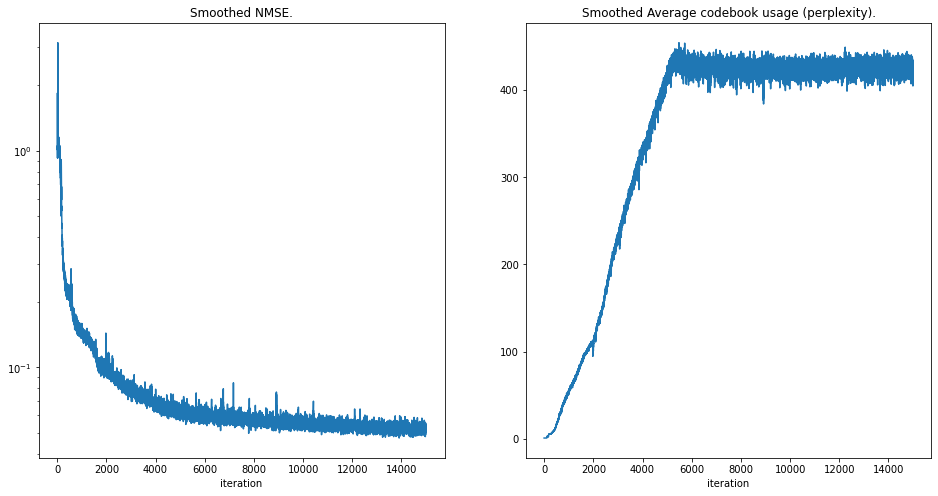

In [25]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [26]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model.pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [27]:
(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [29]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

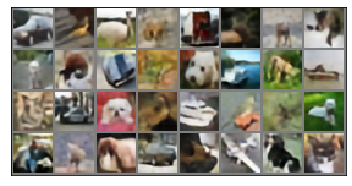

In [30]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

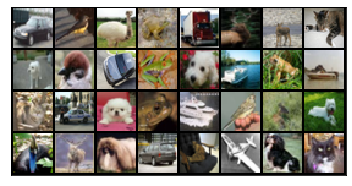

In [31]:
show(make_grid(valid_originals.cpu()+0.5))

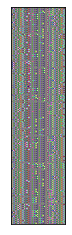

In [32]:
show(make_grid(train_reconstructions.cpu().data)+0.5, )

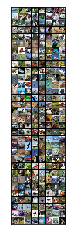

In [33]:
show(make_grid(train_originals.cpu()+0.5))

In [34]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae.embedding.weight.data.cpu())

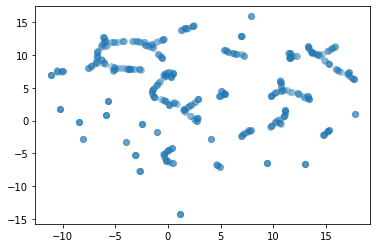

In [35]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3) 